<a href="https://colab.research.google.com/github/morreh89/Loan-Default-Prediction/blob/master/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Challenge:**

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.

1) willingness to pay and

2) ability to pay. 

Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.
These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

**1.1 Problem**

The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. 


**Description of the data**

There are 3 different datasets for both train and test

**Demographic data (traindemographics.csv)**

- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not -  compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)



**Performance data (trainperf.csv)** 

This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict


**Previous loans data (trainprevloans.csv)**

This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)




In [ ]:
import pandas as pd                             #import pandas for dataframe manipulation
import numpy as np                              #import numerical python
import seaborn as sns                           #seaborn for visuals
import matplotlib as mpl                        #matplot for plotting
import matplotlib.pyplot as plt                 #matplot for plotting
import itertools
import datetime as dt                           #convert date formats
from scipy import stats  

from IPython.display import display             # Allows the use of display() for DataFrames
import warnings                                 # Suppress warnings 
warnings.filterwarnings('ignore') 
import os                                       # File system manangement
import gc                                       # memory managemen

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load The Data **


In [ ]:
#Read datasets
traindemographics = pd.read_csv('traindemographics.csv', parse_dates=['birthdate'])
testdemographics = pd.read_csv('testdemographics.csv', parse_dates=['birthdate'])
trainperf = pd.read_csv('trainperf.csv', parse_dates=['approveddate','creationdate'])
testperf = pd.read_csv('testperf.csv',parse_dates=['approveddate','creationdate'])
trainprevloans= pd.read_csv('trainprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                           'firstduedate','firstrepaiddate'])
testprevloans = pd.read_csv('testprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                          'firstduedate','firstrepaiddate'])

**Checking The Shapes of data loaded**

In [ ]:
# Check The Shapes
print('Test Demographic shape: {} Rows, {} Columns'.format(*trainperf.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*traindemographics.shape))
print('Test Previous Loan shape: {} Rows, {} Columns'.format(*trainprevloans.shape))
print('Train Demographic shape: {} Rows, {} Columns'.format(*testperf.shape))
print('Train Performance shape: {} Rows, {} Columns'.format(*testdemographics.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*testprevloans.shape))

Test Demographic shape: 4368 Rows, 10 Columns
Test Performance shape: 4346 Rows, 9 Columns
Test Previous Loan shape: 18183 Rows, 12 Columns
Train Demographic shape: 1450 Rows, 9 Columns
Train Performance shape: 1487 Rows, 9 Columns
Train Previous Loan shape: 5907 Rows, 12 Columns


**Checking the rows**

In [ ]:
# Print First Three Rows Of The Data loaded
display("test demographics")
display(testdemographics.head(3))
display("test performance")
display(testperf.head(3))
display("test previous loans")
display(testprevloans.head(3))
display("train demographics")
display(traindemographics.head(3))
display("train performance")
display(trainperf.head(3))
display("train previous loans")
display(trainprevloans.head(3))

'test demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN


'test performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN


'test previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.0,13000.0,30,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.0,36800.0,60,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22,2017-03-04 09:28:16,30000.0,34400.0,30,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46


'train demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN


'train performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good


'train previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47



## **Data Exploration**

Column/Variable Names


In [ ]:

display("test demographics")
display(testdemographics.columns)
display("test performance")
display(testperf.columns)
display("test previous loans")
display(testprevloans.columns)
display("train demographics")
display(traindemographics.columns)
display("train performance")
display(trainperf.columns)
display("train previous loans")
display(trainprevloans.columns)

'test demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'test performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby'],
      dtype='object')

'test previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

'train demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'train performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

'train previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

Now look at the number of columns of each data type

In [ ]:
# Number of each type of column
display("test demographics")
display(testdemographics.dtypes.value_counts())
display("test performance")
display(testperf.dtypes.value_counts())
display("test previous loans")
display(testprevloans.dtypes.value_counts())
display("train demographics")
display(traindemographics.dtypes.value_counts())
display("train performance")
display(trainperf.dtypes.value_counts())
display("train previous loans")
display(trainprevloans.dtypes.value_counts())

'test demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'test performance'

object     4
int64      4
float64    1
dtype: int64

'test previous loans'

datetime64[ns]    5
int64             3
object            2
float64           2
dtype: int64

'train demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'train performance'

object            3
int64             3
float64           2
datetime64[ns]    2
dtype: int64

'train previous loans'

datetime64[ns]    5
int64             3
object            2
float64           2
dtype: int64

##**Data Preparation**

**Merging the datasets**

tag the data with a set column specifying whether its from train or test set

In [ ]:

traindemographics['set'] = 'train'
testdemographics['set'] = 'test'
trainperf['set'] = 'train'
testperf['set'] = 'test'
trainprevloans['set'] = 'train'
testprevloans['set'] = 'test'

In [ ]:
Tdemographics=pd.concat([traindemographics,testdemographics])
Tperfomance=pd.concat([trainperf,testperf])
Tprevious=pd.concat([trainprevloans,testprevloans])

In [ ]:
# Convert the good_bad_flag into numerical binary variable 
goodbad={'Good':1,'Bad':0}
Tperfomance.good_bad_flag=Tperfomance.good_bad_flag.map(goodbad)

In [ ]:
Tperfomance.head()


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,1.0,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,1.0,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,1.0,train
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,1.0,train
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,1.0,train


In [ ]:
Tperfomance['set'].value_counts(normalize=True) * 100

train    75.077346
test     24.922654
Name: set, dtype: float64

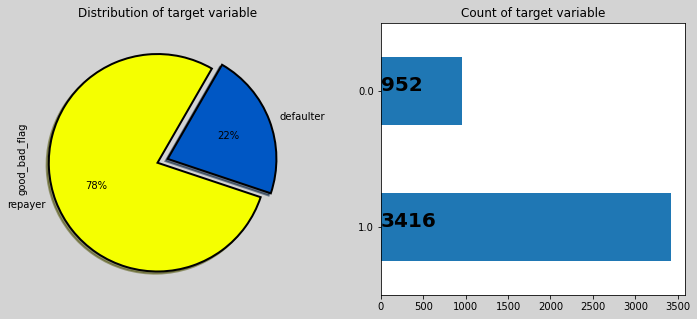

In [ ]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),
                                                                             startangle = 60,
                                            labels=["repayer","defaulter"],wedgeprops={"linewidth":2,"edgecolor":"k"},
                                            explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot(kind="barh")

for i,j in enumerate(Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

22% of the clients are defaulters. This is so high from the global default rate of 2.1% in 2018 

Checking for missing values in the performance train and test data

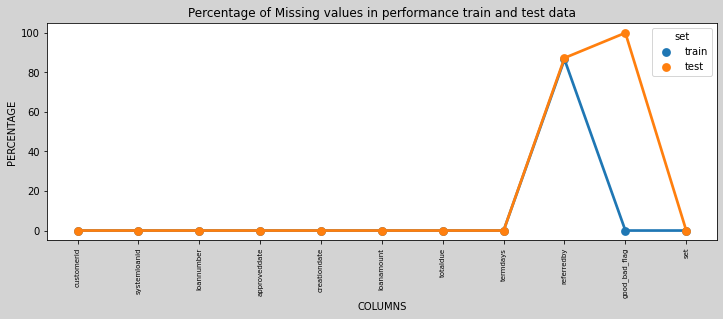

In [ ]:

fig = plt.figure(figsize=(12,4))
miss_train = pd.DataFrame((Tperfomance[Tperfomance['set'] == "train"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "train"].shape[0]).reset_index()
miss_test  = pd.DataFrame((Tperfomance[Tperfomance['set'] == "test"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "test"].shape[0]).reset_index()
miss_train["set"] = "train"
miss_test["set"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="set")
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in performance train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

Checking the percentage of missing values in the rest of the datasets

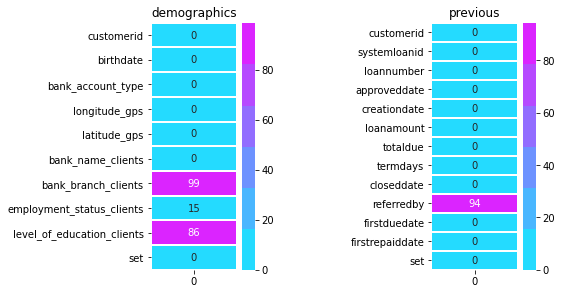

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(Tdemographics.isnull().sum()/Tdemographics.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("demographics")

plt.subplot(232)
sns.heatmap(pd.DataFrame(Tprevious.isnull().sum()/Tprevious.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("previous")

plt.subplots_adjust(wspace = 1.6)

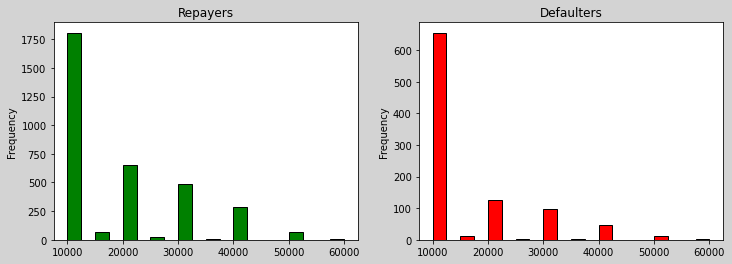

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Tperfomance[Tperfomance['good_bad_flag'] == 1].loanamount.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
Tperfomance[Tperfomance['good_bad_flag'] == 0].loanamount.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

## Feature Engineering

In [ ]:
Tprevious.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,train
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,train
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,train
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43,train
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35,train


In [ ]:
Tprevious.loanamount.unique()

array([10000., 20000., 30000., 40000., 25000., 15000.,  5000.,  8000.,
       50000.,  9000., 35000.,  7000.,  4000.,  6000.,  3000., 60000.,
        1000.,  2000.])

In [ ]:
Tprevious['loanapproval'] = Tprevious['approveddate'] - Tprevious['creationdate']

In [ ]:
import datetime as dt
Tprevious['loanapproval'] = Tprevious['loanapproval']/np.timedelta64(1,'h')

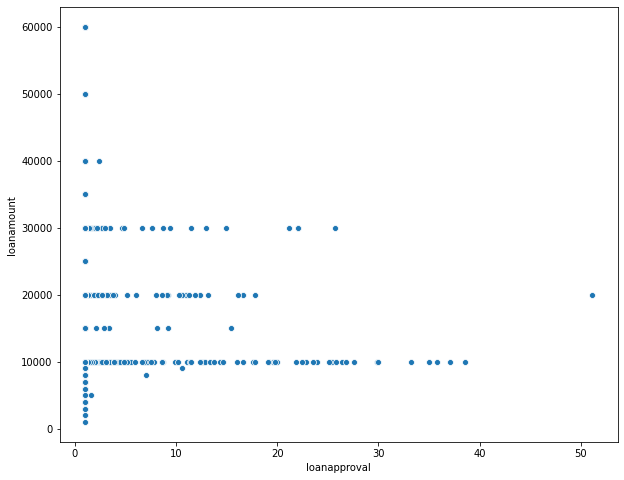

In [ ]:
plt.figure(figsize=(10.0, 8.0))
sns.scatterplot(Tprevious['loanapproval'], Tprevious['loanamount'])

In [ ]:
averageloanamount = Tprevious.groupby('customerid')['loanamount'].mean().to_frame().reset_index()
averageloanamount.rename(columns={'loanamount': 'average_loanamount'}, inplace=True)
Tprevious = pd.merge(Tprevious, averageloanamount, how='left', on='customerid')

In [ ]:
num_loans = Tprevious.groupby('customerid')['systemloanid'].count().to_frame().reset_index()
num_loans.rename(columns = {'systemloanid': 'num_loans'}, inplace=True)
Tprevious = pd.merge(Tprevious, num_loans, how='left', on='customerid')

In [ ]:
Tprevious['firstrepaiddate'] = Tprevious['firstrepaiddate'].astype('datetime64[ns]')
Tprevious['diff'] = (Tprevious['firstrepaiddate'] - Tprevious['firstduedate']).dt.days

In [ ]:
average_diff = Tprevious.groupby('customerid')['diff'].mean().to_frame().reset_index()
average_diff.rename(columns={'diff':'average_diff'}, inplace=True)
Tprevious = pd.merge(Tprevious, average_diff, how='left', on='customerid')

In [ ]:
Tprevious.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,set,loanapproval,average_loanamount,num_loans,diff,average_diff
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,train,1.002222,18181.818182,11,-13,-0.909091
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,train,1.003889,18181.818182,11,-4,-0.909091
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,train,1.001667,18181.818182,11,22,-0.909091
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43,train,1.003611,10000.000000,6,0,0.833333
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35,train,1.001944,10000.000000,2,11,7.500000


In [ ]:
average_termdays = Tprevious.groupby('customerid')['termdays'].mean().to_frame().reset_index()
average_termdays.rename(columns={'termdays':'average_termdays'}, inplace=True)
Tprevious = pd.merge(Tprevious, average_termdays, how='left', on='customerid')

In [ ]:
average_totaldue = Tprevious.groupby('customerid')['totaldue'].mean().to_frame().reset_index()
average_totaldue.rename(columns={'totaldue':'average_totaldue'}, inplace=True)
Tprevious = pd.merge(Tprevious, average_totaldue, how='left', on='customerid')

In [ ]:
Tprevious.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate', 'set', 'loanapproval',
       'average_loanamount', 'num_loans', 'diff', 'average_diff',
       'average_termdays', 'average_totaldue'],
      dtype='object')

In [ ]:
merge_Tprevious = Tprevious[['customerid', 'loanapproval',
       'average_loanamount', 'num_loans','average_diff',
       'average_termdays', 'average_totaldue']]

In [ ]:
merge_Tprevious = merge_Tprevious[~merge_Tprevious.customerid.duplicated()]

In [ ]:
merge_Tprevious.shape

(5801, 7)

In [ ]:
Tdemographics = Tdemographics[~Tdemographics.customerid.duplicated()]
Tdemographics['age']= round((dt.date.today() - Tdemographics.birthdate.dt.date).dt.days/365, 0)
Tdemographics.drop('set', axis='columns', inplace=True)  #Dropped set because we will use the set(train/test data) from Tperformance dataset

In [ ]:
Tdemographics.shape

(5818, 10)

In [ ]:
demographics_previous = pd.merge(Tdemographics, merge_Tprevious, on='customerid', how='left')

In [ ]:
demographics_previous.shape

(5818, 16)

In [ ]:
demographics_previous.head(5)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age,loanapproval,average_loanamount,num_loans,average_diff,average_termdays,average_totaldue
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,47.0,1.018611,10000.0,1.0,-1.000000,15.0,11500.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,35.0,1.018889,10000.0,1.0,3.000000,30.0,13000.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,33.0,1.001944,10000.0,3.0,0.333333,20.0,12000.0
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,29.0,1.018889,10000.0,1.0,18.000000,15.0,11500.0
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,38.0,1.001667,12000.0,5.0,-6.800000,15.0,13575.0


In [ ]:
Tperfomance.shape

(5818, 11)

In [ ]:
final_df = pd.merge(demographics_previous, Tperfomance, on='customerid', how='inner')

In [ ]:
final_df.shape

(5818, 26)

In [ ]:
final_df.isnull().sum().sort_values(ascending=False)/final_df.shape[0] * 100

bank_branch_clients           98.882778
referredby                    86.748023
level_of_education_clients    86.335510
good_bad_flag                 24.922654
employment_status_clients     14.867652
num_loans                      0.292197
average_totaldue               0.292197
average_termdays               0.292197
average_diff                   0.292197
average_loanamount             0.292197
loanapproval                   0.292197
birthdate                      0.000000
bank_account_type              0.000000
longitude_gps                  0.000000
latitude_gps                   0.000000
bank_name_clients              0.000000
set                            0.000000
age                            0.000000
systemloanid                   0.000000
loannumber                     0.000000
approveddate                   0.000000
creationdate                   0.000000
loanamount                     0.000000
totaldue                       0.000000
termdays                       0.000000


In [ ]:
final_df[['average_diff','average_termdays', 'average_totaldue','num_loans','average_loanamount','loanapproval']] = final_df[['average_diff','average_termdays', 'average_totaldue','num_loans','average_loanamount','loanapproval']].fillna(value=0)

In [ ]:
final_df.isnull().sum().sort_values(ascending=False)/final_df.shape[0] * 100

bank_branch_clients           98.882778
referredby                    86.748023
level_of_education_clients    86.335510
good_bad_flag                 24.922654
employment_status_clients     14.867652
set                            0.000000
average_loanamount             0.000000
birthdate                      0.000000
bank_account_type              0.000000
longitude_gps                  0.000000
latitude_gps                   0.000000
bank_name_clients              0.000000
age                            0.000000
loanapproval                   0.000000
num_loans                      0.000000
average_diff                   0.000000
average_termdays               0.000000
average_totaldue               0.000000
systemloanid                   0.000000
loannumber                     0.000000
approveddate                   0.000000
creationdate                   0.000000
loanamount                     0.000000
totaldue                       0.000000
termdays                       0.000000


In [ ]:
final_df = final_df[['customerid', 'age', 'bank_name_clients','bank_account_type', 'bank_branch_clients','longitude_gps',
       'latitude_gps', 'employment_status_clients', 'level_of_education_clients', 'loanapproval', 'num_loans','average_loanamount', 
       'average_termdays', 'average_diff',  'average_totaldue', 'referredby', 'good_bad_flag', 'set']]


In [ ]:
final_df.head(3)

,customerid,age,bank_name_clients,bank_account_type,bank_branch_clients,longitude_gps,latitude_gps,employment_status_clients,level_of_education_clients,loanapproval,num_loans,average_loanamount,average_termdays,average_diff,average_totaldue,referredby,good_bad_flag,set
0,8a858e135cb22031015cbafc76964ebd,47.0,GT Bank,Savings,NaN,3.319219,6.528604,NaN,NaN,1.018611,1.0,10000.0,15.0,-1.000000,11500.0,8a858899538ddb8e0153a780c56e34bb,1.0,train
1,8a858e275c7ea5ec015c82482d7c3996,35.0,Sterling Bank,Savings,NaN,3.325598,7.119403,Permanent,NaN,1.018889,1.0,10000.0,30.0,3.000000,13000.0,NaN,0.0,train
2,8a858e5b5bd99460015bdc95cd485634,33.0,Fidelity Bank,Savings,NaN,5.746100,5.563174,NaN,NaN,1.001944,3.0,10000.0,20.0,0.333333,12000.0,NaN,1.0,train


In [ ]:
#Filling missing values
final_df['bank_branch_clients'].fillna('Unknown', inplace=True)
final_df['employment_status_clients'].fillna('Unknown', inplace=True)
final_df['good_bad_flag'].fillna('Unknown', inplace=True)

In [ ]:
final_df.drop('level_of_education_clients', axis='columns', inplace=True)  #Dropped because it has 5023 misssing records

In [ ]:
print(final_df.isnull().sum())
final_df.to_csv('final_df')

customerid                      0
age                             0
bank_name_clients               0
bank_account_type               0
bank_branch_clients             0
longitude_gps                   0
latitude_gps                    0
employment_status_clients       0
loanapproval                    0
num_loans                       0
average_loanamount              0
average_termdays                0
average_diff                    0
average_totaldue                0
referredby                   5047
good_bad_flag                   0
set                             0
dtype: int64


In [ ]:
final_df.head(3)

,customerid,age,bank_name_clients,bank_account_type,bank_branch_clients,longitude_gps,latitude_gps,employment_status_clients,loanapproval,num_loans,average_loanamount,average_termdays,average_diff,average_totaldue,referredby,good_bad_flag,set
0,8a858e135cb22031015cbafc76964ebd,47.0,GT Bank,Savings,Unknown,3.319219,6.528604,Unknown,1.018611,1.0,10000.0,15.0,-1.000000,11500.0,8a858899538ddb8e0153a780c56e34bb,1,train
1,8a858e275c7ea5ec015c82482d7c3996,35.0,Sterling Bank,Savings,Unknown,3.325598,7.119403,Permanent,1.018889,1.0,10000.0,30.0,3.000000,13000.0,NaN,0,train
2,8a858e5b5bd99460015bdc95cd485634,33.0,Fidelity Bank,Savings,Unknown,5.746100,5.563174,Unknown,1.001944,3.0,10000.0,20.0,0.333333,12000.0,NaN,1,train


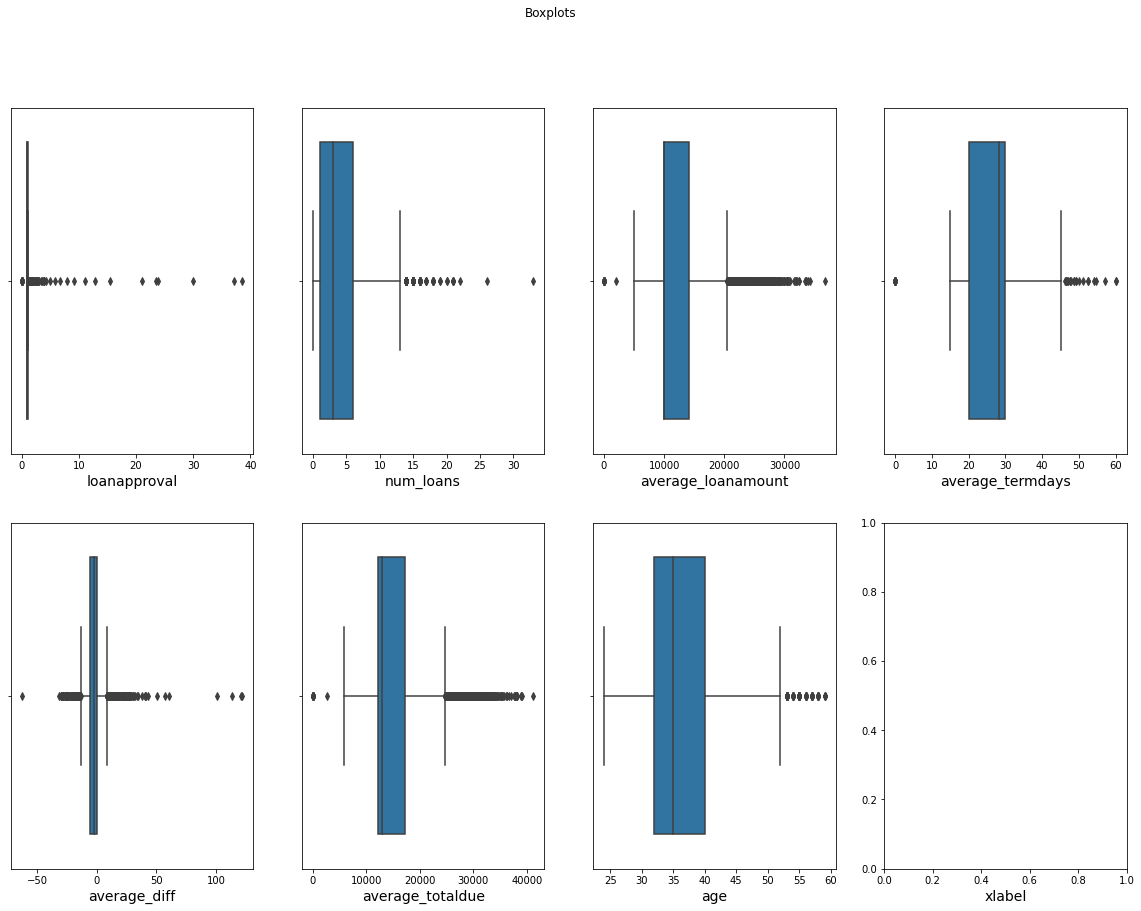

In [ ]:
#Detecting outliers

# Checking for Outliers
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 14))
fig.suptitle('Boxplots')
ax1.set_xlabel('xlabel',fontsize=14)
ax2.set_xlabel('xlabel',fontsize=14)
ax3.set_xlabel('xlabel',fontsize=14)
ax4.set_xlabel('xlabel',fontsize=14)
ax5.set_xlabel('xlabel',fontsize=14)
ax6.set_xlabel('xlabel',fontsize=14)
ax7.set_xlabel('xlabel',fontsize=14)
ax8.set_xlabel('xlabel',fontsize=14)
sns.boxplot(final_df['loanapproval'], ax=ax1)
sns.boxplot(final_df['num_loans'], ax=ax2)
sns.boxplot(final_df['average_loanamount'], ax=ax3)
sns.boxplot(final_df['average_termdays'], ax=ax4)
sns.boxplot(final_df['average_diff'], ax=ax5)
sns.boxplot(final_df['average_totaldue'], ax=ax6)
sns.boxplot(final_df['age'], ax=ax7)



In [ ]:
# Calculating our first, third quantiles and then later our IQR

#
Q1= final_df.quantile(0.25)
Q3 =final_df.quantile(0.75)
IQR = Q3-Q1
print('0.25 quatile')
print(Q1)
print('----------------------------------------')
print('0.75 quatile')
print(Q3)
print('----------------------------------------')
print('Interquatile')
print(IQR)

0.25 quatile
age                      32.000000
longitude_gps             3.354953
latitude_gps              6.473605
loanapproval              1.001944
num_loans                 1.000000
average_loanamount    10000.000000
average_termdays         20.000000
average_diff             -5.444444
average_totaldue      12250.000000
Name: 0.25, dtype: float64
----------------------------------------
0.75 quatile
age                      40.000000
longitude_gps             6.556336
latitude_gps              7.426570
loanapproval              1.018611
num_loans                 6.000000
average_loanamount    14166.666667
average_termdays         30.000000
average_diff              0.000000
average_totaldue      17218.750000
Name: 0.75, dtype: float64
----------------------------------------
Interquatile
age                      8.000000
longitude_gps            3.201383
latitude_gps             0.952965
loanapproval             0.016667
num_loans                5.000000
average_loanamount    416

## Univariate Analysis 

In [ ]:
#Descriptive Analysis 
print('Variance of values in different columns')
print(final_df.var())
print('Skewness of values in different columns')
print(final_df.skew())
print('Kurtosis of values in different columns')
print(final_df.kurt())
print('Summary')
final_df.describe()


Variance of values in different columns
age                   3.829444e+01
longitude_gps         4.876899e+01
latitude_gps          9.285362e+00
loanapproval          9.873541e-01
num_loans             1.339470e+01
average_loanamount    2.330024e+07
average_termdays      4.843330e+01
average_diff          6.113570e+01
average_totaldue      2.913803e+07
dtype: float64
Skewness of values in different columns
age                    0.680720
longitude_gps         -4.953080
latitude_gps           4.936300
loanapproval          28.461298
num_loans              1.366874
average_loanamount     1.693166
average_termdays      -0.169311
average_diff           2.858254
average_totaldue       1.631172
dtype: float64
Kurtosis of values in different columns
age                     0.472441
longitude_gps         223.222967
latitude_gps          214.389552
loanapproval          905.831280
num_loans               1.899798
average_loanamount      2.463542
average_termdays        0.178839
average_diff    

,age,longitude_gps,latitude_gps,loanapproval,num_loans,average_loanamount,average_termdays,average_diff,average_totaldue
count,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000
mean,36.161224,4.576024,7.220867,1.056481,4.140598,12816.342453,25.294889,-2.330241,15537.558471
std,6.188250,6.983480,3.047189,0.993657,3.659878,4827.031846,6.959403,7.818932,5397.965322
min,24.000000,-149.033700,-74.005974,0.000000,0.000000,0.000000,0.000000,-63.000000,0.000000
25%,32.000000,3.354953,6.473605,1.001944,1.000000,10000.000000,20.000000,-5.444444,12250.000000
50%,35.000000,3.588480,6.621319,1.003056,3.000000,10000.000000,28.125000,-2.333333,13000.000000
75%,40.000000,6.556336,7.426570,1.018611,6.000000,14166.666667,30.000000,0.000000,17218.750000
max,59.000000,151.209290,71.228069,38.591944,33.000000,36666.666667,60.000000,122.000000,41252.380952


It takes around 1 hour before a loan is approved. However the highest time is 38hoursthat is around 1 day and 14hours which is quite slow. 

The mean age that borrows money is 36years. This is clearly those who are working and have taken a lot of responsibilities in the past 10 years of their life 


The average defaulting rate is 2 days which is moderate. Though every lenders goal is to have no-one default as defaulting increases risk of bad debt 

Previous years analysis

Text(0.5, 1.0, 'Total loans predicted in the previous year per month ')

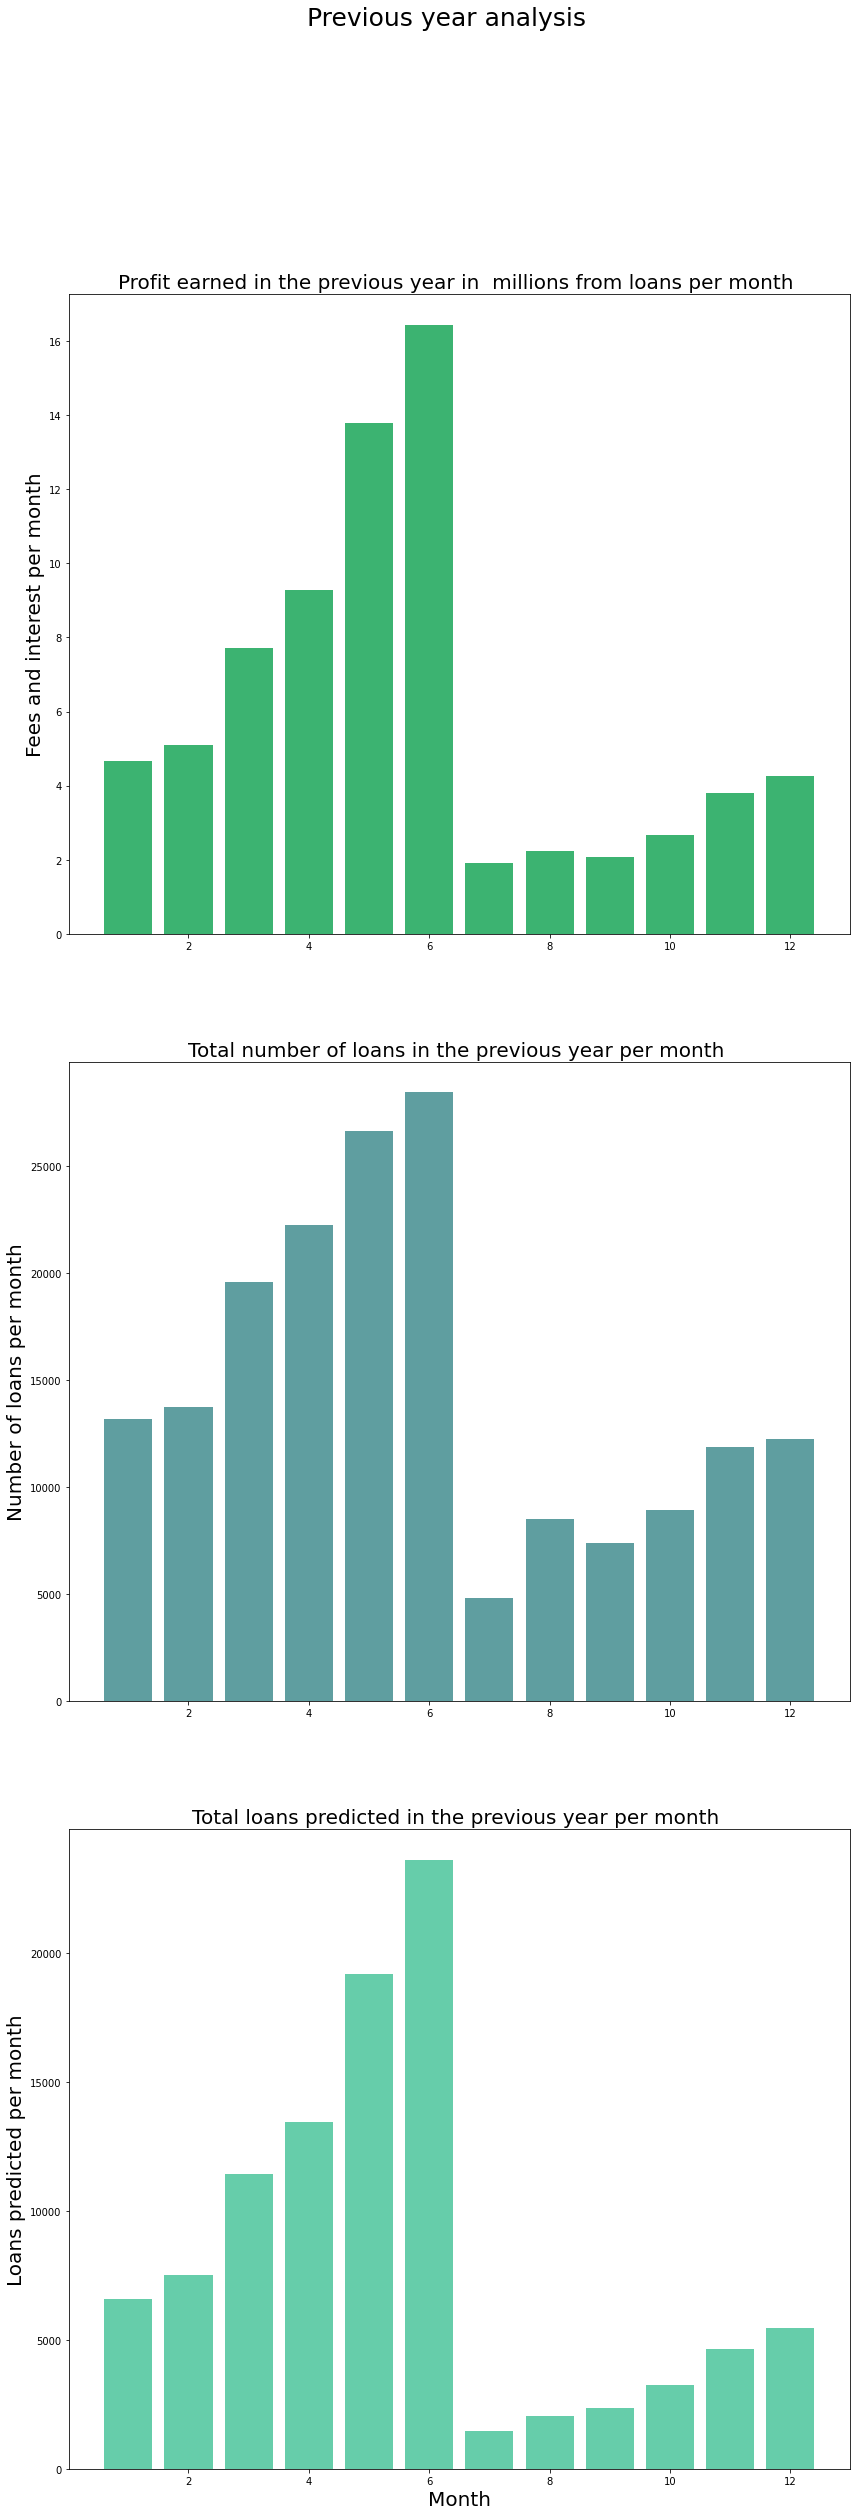

In [ ]:
#Find totals by month in previous years 
df= Tprevious
import datetime 
from datetime import  datetime
df.creationdate.sort_values(ascending=True)
df.set_index(pd.DatetimeIndex(df['creationdate']), drop=True, inplace = True)
df['profit_by_bank'] =( df.totaldue -df.loanamount)/1000000
df=df.groupby([df.index.month]).sum()
#Plotting 
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 40))
fig.suptitle('Previous year analysis', fontsize=25)
plt.xlabel("Month", fontsize=20)
ax1.bar(df.index, df.profit_by_bank, color='mediumseagreen')
ax1.set_ylabel("Fees and interest per month", fontsize=20)
ax1.set_title("Profit earned in the previous year in  millions from loans per month ", fontsize=20)
ax2.bar(df.index, df.num_loans, color='cadetblue')
ax2.set_ylabel("Number of loans per month", fontsize=20)
ax2.set_title("Total number of loans in the previous year per month ", fontsize=20)
ax3.bar(df.index, df.loannumber, color='mediumaquamarine')
ax3.set_ylabel("Loans predicted per month", fontsize=20)
ax3.set_title("Total loans predicted in the previous year per month ", fontsize=20)

**Customers** seem to borrow the most in June and the lowest in July. This might be due to the fact that its the mid year. After mid year. The rate of borrowing significantly decreases 

Client Analysis

Text(0, 0.5, 'Count')

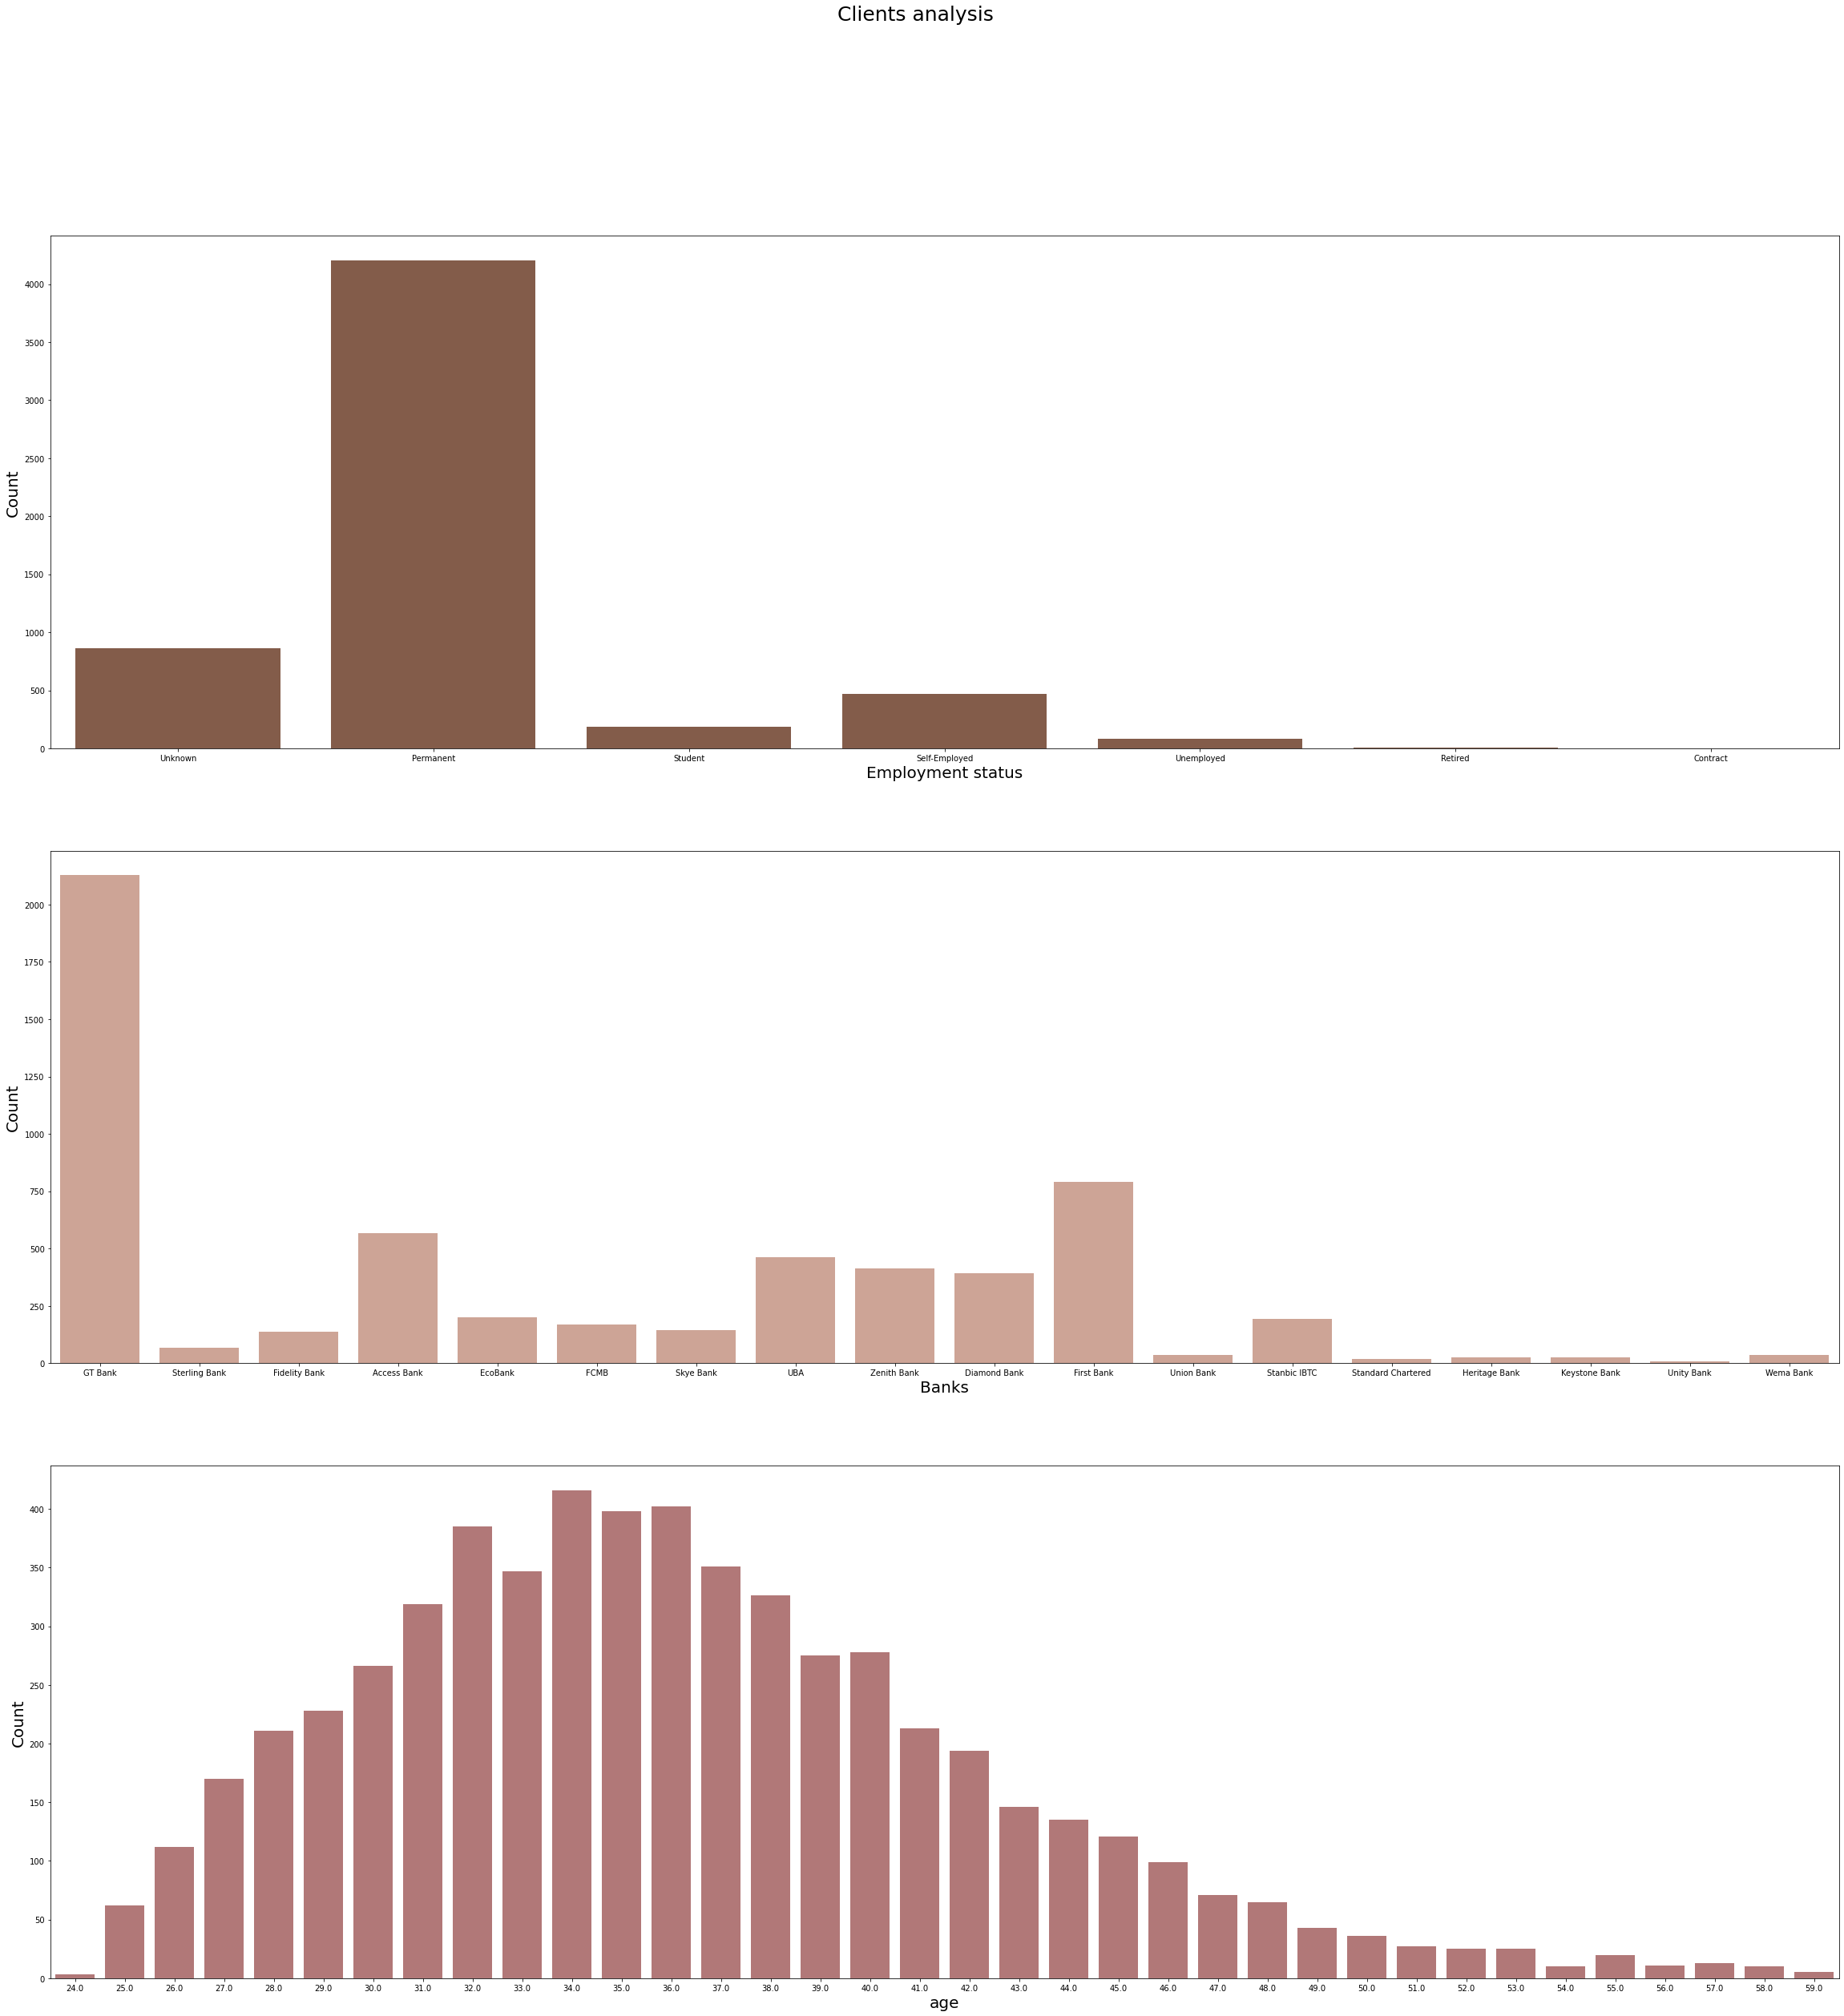

In [ ]:
import matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(40, 40)) 
fig.suptitle('Clients analysis', fontsize=25)
sns.countplot(final_df['employment_status_clients'], color='sienna',saturation=0.5, ax=ax1)
sns.countplot(final_df['bank_name_clients'], color='darksalmon',saturation=0.5, ax=ax2 )
sns.countplot(final_df['age'], color='indianred',saturation=0.5, ax=ax3)
ax1.set_xlabel('Employment status', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax2.set_xlabel('Banks', fontsize=20)
ax2.set_ylabel('Count', fontsize=20)
ax3.set_xlabel('age', fontsize=20)
ax3.set_ylabel('Count', fontsize=20)

**Findings on clients details**


Most people that borrow money are permanetely employed

GT bank has the highest number of clients that borrow money

People between the ages of 30-40 years have the highest borrowing rate 


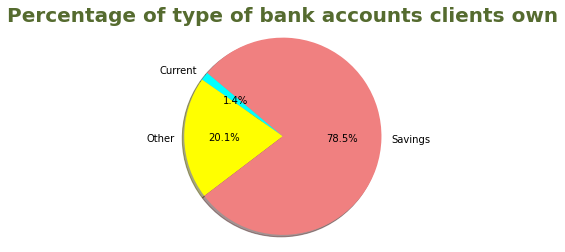

In [ ]:
#The type of bank accounts clients own 
bankaccounttype = final_df[['employment_status_clients','bank_account_type']]
new_df = bankaccounttype.groupby('bank_account_type')['employment_status_clients'].count()
new_df =pd.DataFrame({'bank_account_type':new_df.index, 'employment_status_clients':new_df.values})
new_df
employment= new_df['employment_status_clients']
bank_account= new_df['bank_account_type']
colors_list = ['cyan', 'yellow', 'lightcoral']
plt.title("Percentage of type of bank accounts clients own",
     color = 'darkolivegreen', fontweight = 'bold', fontsize = '20')
plt.pie(employment, labels=bank_account, autopct='%1.1f%%', shadow=True, startangle=140, colors=colors_list)
plt.axis('equal')
plt.show()

Most people that borrow own savings accounts.

This is a good thing as savings act as securities to most clients 


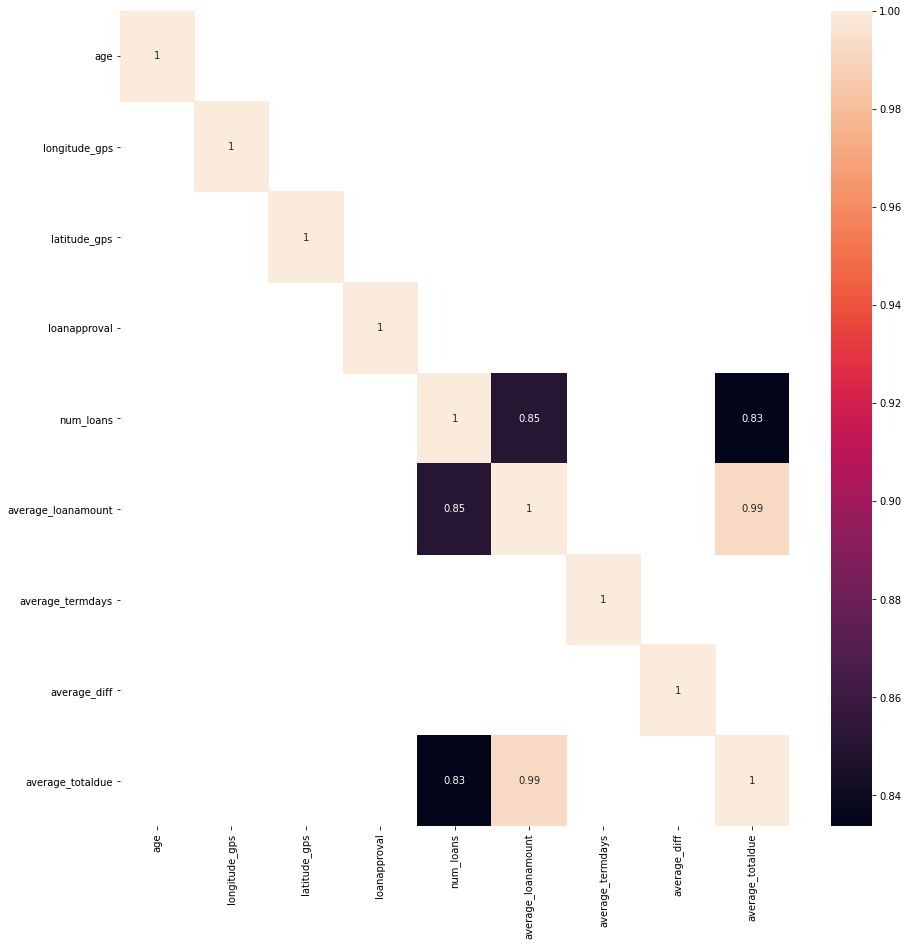

In [ ]:
correlation_mat = final_df.corr()
Greaterthan= correlation_mat[correlation_mat > 0.5]
plt.show()
plt.figure(figsize=(15,15))
sns.heatmap(Greaterthan,annot=True )
plt.show()

There is a high correlation between number of loans and how much they borrow. Means that most people continue borrrowing more money as they take new loans 

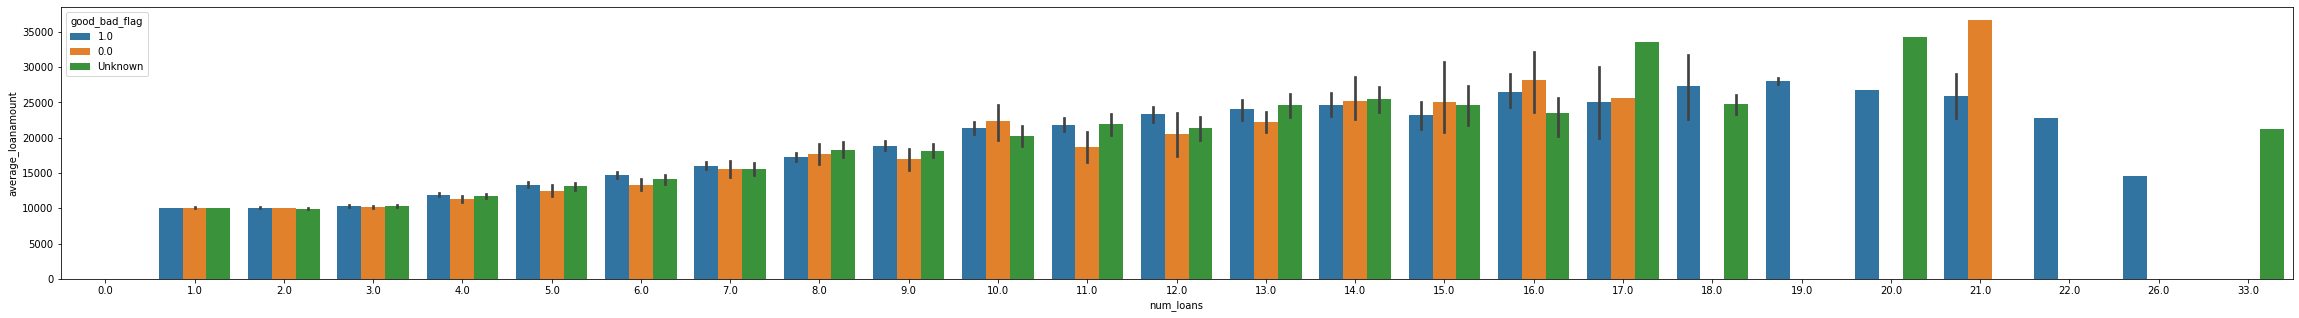

In [ ]:
plt.figure(figsize=(40,5))
sns.barplot(x= 'num_loans', y ='average_loanamount',data= final_df, hue='good_bad_flag')

**Findings**


The number of loans increases with the loanamount they borrow 

The more they are they borrow loans and the more the loan amount, the more likely they are to be defaulters. For example those who borrowed loans 21 times
 at an average of 35000 shillings recorded the highest default status 


However those who borrow less money but borrow more times are good repayers 


Those who borrow moderately have a 50-50 chance of repaying and defaulting  

<Figure size 2880x360 with 0 Axes>

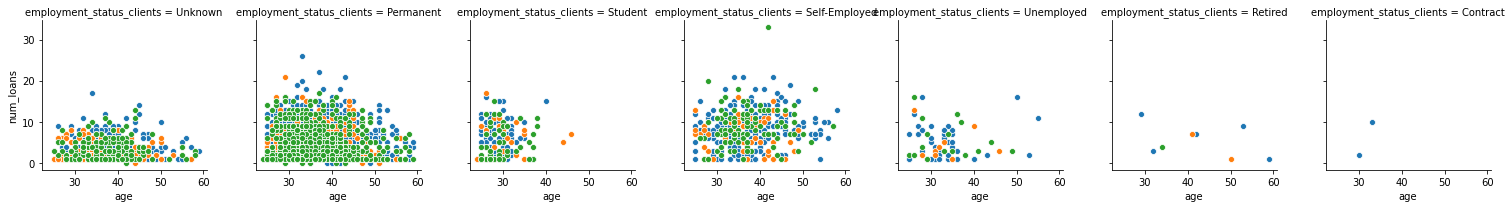

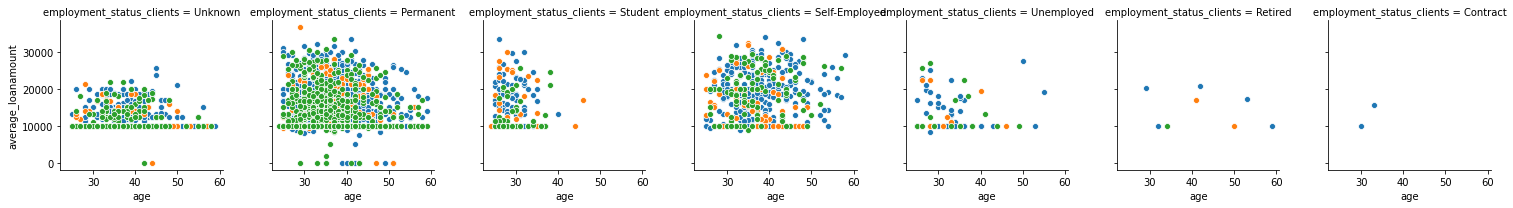

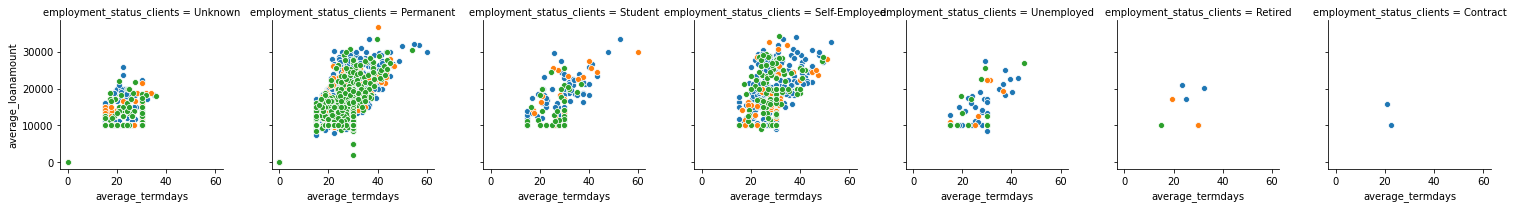

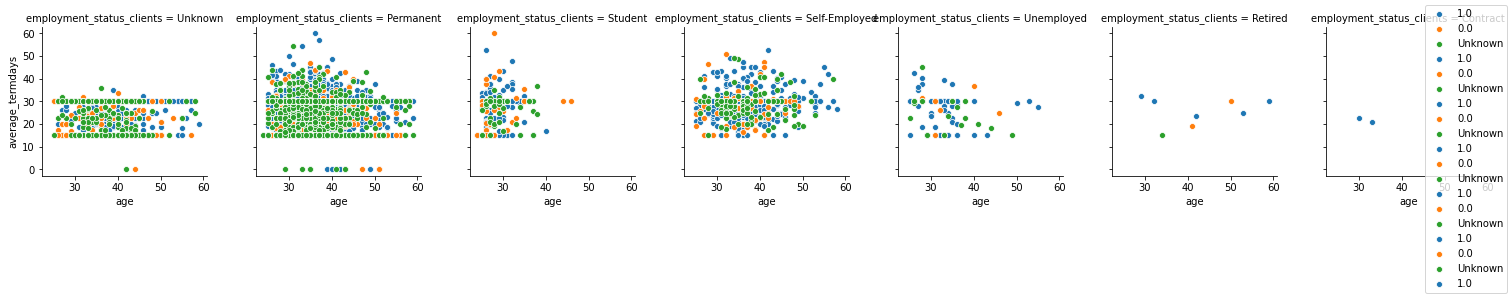

In [ ]:
plt.figure(figsize=(40,5))
cond_plot = sns.FacetGrid(data=final_df, col='employment_status_clients', hue='good_bad_flag', col_wrap=7)
cond_plot.map(sns.scatterplot, 'age','num_loans');
cond_plot2 = sns.FacetGrid(data=final_df, col='employment_status_clients', hue='good_bad_flag', col_wrap=7)
cond_plot2.map(sns.scatterplot, 'age','average_loanamount');
cond_plot3 = sns.FacetGrid(data=final_df, col='employment_status_clients', hue='good_bad_flag', col_wrap=7)
cond_plot3.map(sns.scatterplot, 'average_termdays','average_loanamount');
cond_plot4 = sns.FacetGrid(data=final_df, col='employment_status_clients', hue='good_bad_flag', col_wrap=7)
cond_plot4.map(sns.scatterplot, 'age','average_termdays');
cond_plot4.fig.legend()

## Hypothesis Testing

In [ ]:
hypothesis_df = final_df[final_df['set'] == 'train']

In [ ]:
hypothesis_df.shape

(4368, 17)

- Population size: 4368
- Margin of error: 5%
- Confidence Level: 95%
- Sample size: 354

In [ ]:
agebins = [18,30,45,60]
labels=['18-30','31-45','46-60']
hypothesis_df['agecategory'] = pd.cut(hypothesis_df['age'], bins=agebins, labels=labels, include_lowest=True)
hypothesis_df['agecategory'].unique()

[46-60, 31-45, 18-30]
Categories (3, object): [18-30 < 31-45 < 46-60]

In [ ]:
sample_df = hypothesis_df.sample(354)

- Test 1: Does the age of a customer influence their default behaviour on loans?
 
 1. H0 : Age of customer has no association with their loan default behaviour
 2. H1 : Age of a customer has an association with their loan default behaviour

In [ ]:
table_age = pd.crosstab(sample_df['good_bad_flag'], sample_df['agecategory'])
table_age

agecategory,18-30,31-45,46-60
good_bad_flag,,,
0.0,14,59,14
1.0,43,200,24


In [ ]:
# Perform a chi-square test with alpha 0.05
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_age.to_numpy())

#Calculate critical value, set significance level to 0.05
prob = 0.95
critical_value = chi2.ppf(prob, dof)

print(f'Critical value: {critical_value}, test_statistic: {stat}, alpha: {1-prob}, p_value: {p}')

Critical value: 5.991464547107979, test_statistic: 3.535162450352401, alpha: 0.050000000000000044, p_value: 0.17074548463657646


p value is greater than alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

- Test 2: Does the number of loans that a customer has taken influence their loan default behaviour?
 1. H0 = Average number of loans is equal for both good and bad loans
 2. H1 = Average number of loans != for good and bad loans

In [ ]:
# Perform a ztest with 95% confidence level
from statsmodels.stats.weightstats import ztest

stat, p = ztest(sample_df[sample_df['good_bad_flag'] == 1]['num_loans'], sample_df[sample_df['good_bad_flag'] == 0]['num_loans'])

print(f'Z statistic: {stat}, p_value: {p}, alpha: 0.05')

Z statistic: 2.587012732760006, p_value: 0.00968120146473318, alpha: 0.05


p value is less than alpha thus significant evidence to reject the null hypothesis with 95% confidence.

- Test 3: Does the average time taken for a customer to pay back a loan influence their loan default behaviour?

1. H0: Average number of days to pay back a loan is equal for both good and bad loans.
2. H1: Average number of days to pay back a loan is not equal for both good and bad loans.

In [ ]:
# Perform a ztest with 95% confidence level
from statsmodels.stats.weightstats import ztest

stat, p = ztest(sample_df[sample_df['good_bad_flag'] == 1]['average_diff'], sample_df[sample_df['good_bad_flag'] == 0]['average_diff'])

print(f'Z statistic: {stat}, p_value: {p}, alpha: 0.05')

Z statistic: -6.448168270256521, p_value: 1.1321003334493063e-10, alpha: 0.05


p value is greater than the alpha thus there is lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

- Test 4: Does the average time taken for a customer's loan to get approved influence their loan default behaviour?

1. H0: Average time to get a loan approved is equal for both good and bad loans.
2. H1: Average time to get a loan approved is not equal for both good and bad loans.

In [ ]:
# Perform a ztest with 95% confidence level
from statsmodels.stats.weightstats import ztest

stat, p = ztest(sample_df[sample_df['good_bad_flag'] == 1]['loanapproval'], sample_df[sample_df['good_bad_flag'] == 0]['loanapproval'])

print(f'Z statistic: {stat}, p_value: {p}, alpha: 0.05')

Z statistic: -2.3885700378353825, p_value: 0.01691408409591196, alpha: 0.05


p value is greater than alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

- Test 5: Does the bank that a customer gets a loan from influence their loan default behaviour?
1. H0: There is no association between the bank name and the good_bad_flag variables
2. H1:  There is an association between the bank name and the good_bad_flag variables

In [ ]:
table_bank = pd.crosstab(sample_df['good_bad_flag'], sample_df['bank_name_clients'])
table_bank

bank_name_clients,Access Bank,Diamond Bank,EcoBank,FCMB,Fidelity Bank,First Bank,GT Bank,Heritage Bank,Keystone Bank,Skye Bank,Stanbic IBTC,Standard Chartered,Sterling Bank,UBA,Unity Bank,Wema Bank,Zenith Bank
good_bad_flag,,,,,,,,,,,,,,,,,
0.0,10,1,5,1,0,13,33,0,1,5,1,1,3,5,0,0,8
1.0,29,23,5,6,7,28,92,1,1,10,8,2,3,22,1,4,25


In [ ]:
# Perform a chi-square test with alpha 0.05
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_bank.to_numpy())

#Calculate critical value, set significance level to 0.05
prob = 0.95
critical_value = chi2.ppf(prob, dof)

print(f'Critical value: {critical_value}, test_statistic: {stat}, alpha: {1-prob}, p_value: {p}')

Critical value: 26.29622760486423, test_statistic: 19.84023065582578, alpha: 0.050000000000000044, p_value: 0.22750296825965244


p value is greater than the alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

- Test 6: Does the bank account type that a customer has influence their loan default behaviour?
1. H0: There is no association between the bank account type and the good_bad_flag variables
2. H1:  There is an association between the bank account type and the good_bad_flag variables

In [ ]:
table_account = pd.crosstab(sample_df['good_bad_flag'], sample_df['bank_account_type'])
table_account

bank_account_type,Current,Other,Savings
good_bad_flag,,,
0.0,3,12,72
1.0,7,56,204


In [ ]:
# Perform a chi-square test with alpha 0.05
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_account.to_numpy())

#Calculate critical value, set significance level to 0.05
prob = 0.95
critical_value = chi2.ppf(prob, dof)

print(f'Critical value: {critical_value}, test_statistic: {stat}, alpha: {1-prob}, p_value: {p}')

Critical value: 5.991464547107979, test_statistic: 2.259884201983607, alpha: 0.050000000000000044, p_value: 0.3230519602688761


p value is greater than the alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

- Test 7: Does the employment status of a customer influence their loan default behaviour?
1. H0: There is no association between the employment status and the good_bad_flag variables
2. H1:  There is an association between the employment status and the good_bad_flag variables

In [ ]:
sample2 = hypothesis_df.sample(354)

In [ ]:
table_employment = pd.crosstab(sample2['good_bad_flag'], sample2['employment_status_clients'])
table_employment

employment_status_clients,Permanent,Retired,Self-Employed,Student,Unemployed,Unknown
good_bad_flag,,,,,,
0.0,59,1,5,2,0,15
1.0,196,0,25,12,2,37


In [ ]:
# Perform a chi-square test with alpha 0.05
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_employment.to_numpy())

#Calculate critical value, set significance level to 0.05
prob = 0.95
critical_value = chi2.ppf(prob, dof)

print(f'Critical value: {critical_value}, test_statistic: {stat}, alpha: {1-prob}, p_value: {p}')

Critical value: 11.070497693516351, test_statistic: 6.195010875170066, alpha: 0.050000000000000044, p_value: 0.28770339138551476


p-value is greater than alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

In [ ]:
#Assigning categories to referred by column
hypothesis_df['referredby'] = np.where(hypothesis_df['referredby'].isin(hypothesis_df['referredby'].loc[~hypothesis_df['referredby'].isnull()]), 'referred','not reffered')

In [ ]:
sample_df = hypothesis_df.sample(354)

- Test 8: Does whether a customer is reffered or not influence their default behaviour?
1. H0: No association between reffered by and good_bad_flag variables
2. H1: There is an association between reffered by and good_bad_flag variables

In [ ]:
table_referred = pd.crosstab(sample_df['good_bad_flag'], sample_df['referredby'])
table_referred

referredby,not reffered,referred
good_bad_flag,,
0.0,77,8
1.0,238,31


In [ ]:
# Perform a chi-square test with alpha 0.05
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_referred.to_numpy())

#Calculate critical value, set significance level to 0.05
prob = 0.95
critical_value = chi2.ppf(prob, dof)

print(f'Critical value: {critical_value}, test_statistic: {stat}, alpha: {1-prob}, p_value: {p}')

Critical value: 3.841458820694124, test_statistic: 0.11800482045835192, alpha: 0.050000000000000044, p_value: 0.7312085782483395


p value is greater than the alpha thus lack of significant evidence, we fail to reject the null hypothesis with 95% confidence.

## Modelling

In [ ]:
final_df.head(3)

,customerid,age,bank_name_clients,bank_account_type,bank_branch_clients,longitude_gps,latitude_gps,employment_status_clients,loanapproval,num_loans,average_loanamount,average_termdays,average_diff,average_totaldue,referredby,good_bad_flag,set
0,8a858e135cb22031015cbafc76964ebd,47.0,GT Bank,Savings,Unknown,3.319219,6.528604,Unknown,1.018611,1.0,10000.0,15.0,-1.000000,11500.0,8a858899538ddb8e0153a780c56e34bb,1,train
1,8a858e275c7ea5ec015c82482d7c3996,35.0,Sterling Bank,Savings,Unknown,3.325598,7.119403,Permanent,1.018889,1.0,10000.0,30.0,3.000000,13000.0,NaN,0,train
2,8a858e5b5bd99460015bdc95cd485634,33.0,Fidelity Bank,Savings,Unknown,5.746100,5.563174,Unknown,1.001944,3.0,10000.0,20.0,0.333333,12000.0,NaN,1,train


In [ ]:
#Assigning categories to referred by column
final_df['referredby'] = np.where(final_df['referredby'].isin(final_df['referredby'].loc[~final_df['referredby'].isnull()]), 'referred','not reffered')

In [ ]:
# Split X and Y
from sklearn.model_selection import train_test_split as tts
train_data = final_df[final_df['set'] =='train']
test_data = final_df[final_df['set'] == 'test']

X = train_data.loc[:, train_data.columns != 'good_bad_flag']
Y = train_data['good_bad_flag'].astype(np.int64)

to_drop = ['customerid','bank_name_clients','bank_branch_clients', 'set']
X.drop(to_drop, axis=1, inplace=True)

num_var = X.select_dtypes(include=['float64']).columns
num_data = X[num_var]

obj_var = X.select_dtypes(include=['object']).columns
obj_data = X[obj_var]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(num_data)
num_data = scaler.transform(num_data)

# Encode categorical features
obj_data = pd.get_dummies(obj_data)

#Concatenate scaled and encoded features
X = np.concatenate((num_data, obj_data.to_numpy(dtype=np.float64)), axis=1)

x_train, x_test, y_train, y_test = tts(X, Y, test_size = 0.3, random_state=1)

In [ ]:
print(x_train.shape, x_test.shape)

(3057, 21) (1311, 21)


In [ ]:
# Load models
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
#fitting models
naive_bayes = GaussianNB().fit(x_train, y_train)
support_vector = SVC().fit(x_train, y_train)
random_forest = RandomForestClassifier().fit(x_train,y_train)
xgboost = XGBClassifier().fit(x_train, y_train)

In [ ]:
#Prediction
y_pred_bayes = naive_bayes.predict(x_test)
y_pred_svc = support_vector.predict(x_test)
y_pred_forest = random_forest.predict(x_test)
y_pred_xgb = xgboost.predict(x_test)

## Evaluation

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print(" Naive Bayes accuracy:",metrics.accuracy_score(y_test, y_pred_bayes))
print(" Support Vector Machine accuracy:",metrics.accuracy_score(y_test, y_pred_svc))
print(" Random Forest accuracy:",metrics.accuracy_score(y_test, y_pred_forest))
print(" XGBoost accuracy:",metrics.accuracy_score(y_test, y_pred_xgb))

 Naive Bayes accuracy: 0.2997711670480549
 Support Vector Machine accuracy: 0.7978642257818459
 Random Forest accuracy: 0.7909992372234935
 XGBoost accuracy: 0.7993897787948131


In [ ]:
from sklearn.metrics import classification_report
print(" Naive Bayes accuracy: \n",classification_report(y_test, y_pred_bayes))
print(" Support Vector Machine accuracy \n:",classification_report(y_test, y_pred_svc))
print(" Random Forest accuracy: \n",classification_report(y_test, y_pred_forest))
print(" XGBoost accuracy: \n",classification_report(y_test, y_pred_xgb))




 Naive Bayes accuracy: 
               precision    recall  f1-score   support

           0       0.22      0.90      0.36       281
           1       0.83      0.14      0.23      1030

    accuracy                           0.30      1311
   macro avg       0.53      0.52      0.29      1311
weighted avg       0.70      0.30      0.26      1311

 Support Vector Machine accuracy 
:               precision    recall  f1-score   support

           0       0.71      0.10      0.17       281
           1       0.80      0.99      0.88      1030

    accuracy                           0.80      1311
   macro avg       0.76      0.54      0.53      1311
weighted avg       0.78      0.80      0.73      1311

 Random Forest accuracy: 
               precision    recall  f1-score   support

           0       0.53      0.20      0.29       281
           1       0.81      0.95      0.88      1030

    accuracy                           0.79      1311
   macro avg       0.67      0.58      0

### Imbalanced Classification

In [ ]:
train_data.good_bad_flag.value_counts(normalize=True) * 100

1.0    78.205128
0.0    21.794872
Name: good_bad_flag, dtype: float64

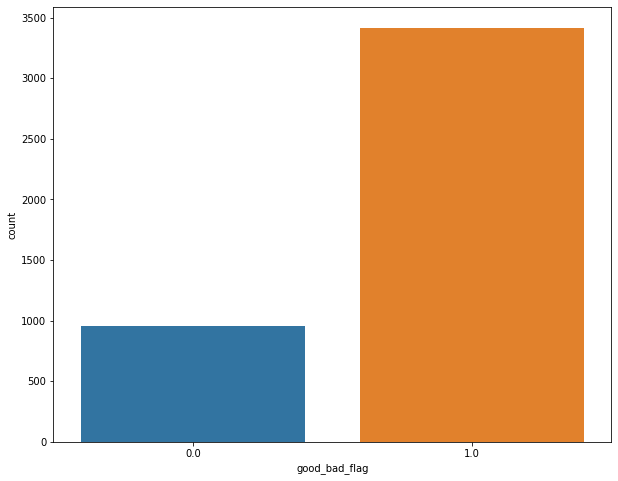

In [ ]:
# Investigate distribution of target variable
plt.figure(figsize=(10.0, 8.0))
sns.countplot(x='good_bad_flag', data=train_data)

The target variable 'good_bad_flag' is quite imbalanced, with good loans having 78% of the data and the bad loans having 21% of the data.

In [ ]:
# Perform stratified sampling in the train test split

x1_train, x1_test, y1_train, y1_test = tts(X, Y, test_size = 0.3, random_state=1, stratify=Y)

In [ ]:
# Load and fit better performing models

support_vector = SVC(probability=True).fit(x1_train, y1_train)
random_forest = RandomForestClassifier().fit(x1_train,y1_train)
xgboost = XGBClassifier().fit(x1_train, y1_train)


y_pred_svc = support_vector.predict(x1_test)
y_pred_forest = random_forest.predict(x1_test)
y_pred_xgb = xgboost.predict(x1_test)

In [ ]:
# Evaluate models

print(" Support Vector Machine accuracy:",metrics.accuracy_score(y1_test, y_pred_svc))
print(" Random Forest accuracy:",metrics.accuracy_score(y1_test, y_pred_forest))
print(" XGBoost accuracy:",metrics.accuracy_score(y1_test, y_pred_xgb))

 Support Vector Machine accuracy: 0.7909992372234935
 Random Forest accuracy: 0.7917620137299771
 XGBoost accuracy: 0.7948131197559115


In [ ]:
from sklearn.metrics import roc_auc_score

y_prob_svc = support_vector.predict_proba(x1_test)
y_prob_forest = random_forest.predict_proba(x1_test)
y_prob_xgb = xgboost.predict_proba(x1_test)


In [ ]:
good_probs_svc = y_prob_svc[:, 1]
bad_probs_svc = y_prob_svc[:, 0]
# Prediction probabilties
print('Support Vector Classifier: ')
print("Good Loans: ", roc_auc_score(y1_test, good_probs_svc))
print("Bad Loans: ", roc_auc_score(y1_test, bad_probs_svc))


Support Vector Classifier: 
Good Loans:  0.6397032236056626
Bad Loans:  0.3602967763943374


In [ ]:
len(good_probs_svc)

1311

In [ ]:
good_probs_forest = y_prob_forest[:, 1]
bad_probs_forest = y_prob_forest[:, 0]
# Prediction probabilties
print('Random Forest Classifier: ')
print("Good Loans: ", roc_auc_score(y1_test, good_probs_forest))
print("Bad Loans: ", roc_auc_score(y1_test, bad_probs_forest))


Random Forest Classifier: 
Good Loans:  0.6516851441241686
Bad Loans:  0.3483148558758315


In [ ]:
good_probs_xgb = y_prob_xgb[:, 1]
bad_probs_xgb = y_prob_xgb[:, 0]
# Prediction probabilties
print('XGBoost Classifier: ')
print("Good Loans: ", roc_auc_score(y1_test, good_probs_xgb))
print("Bad Loans: ", roc_auc_score(y1_test, bad_probs_xgb))


XGBoost Classifier: 
Good Loans:  0.6785502302575473
Bad Loans:  0.3214497697424526


### Upsample Minority Class

In [ ]:
from sklearn.utils import resample

df_good = train_data[train_data['good_bad_flag'] == 1]
df_bad = train_data[train_data['good_bad_flag'] == 0]

In [ ]:
# Check number of good loans
df_good.good_bad_flag.value_counts()

1.0    3416
Name: good_bad_flag, dtype: int64

In [ ]:
# Upsample minority class
df_bad_upsampled = resample(df_bad, 
                                 replace=True,     # sample with replacement
                                 n_samples=3416,    # to match majority class
                                 random_state=24) # reproducible results

In [ ]:
# Combine majority class with upsampled minority class
train_data_upsampled = pd.concat([df_good, df_bad_upsampled])
 
# Display new class counts
train_data_upsampled.good_bad_flag.value_counts()

1.0    3416
0.0    3416
Name: good_bad_flag, dtype: int64

In [ ]:
X1 = train_data_upsampled.loc[:, train_data_upsampled.columns != 'good_bad_flag']
Y1 = train_data_upsampled['good_bad_flag'].astype(np.int64)

to_drop = ['customerid','bank_name_clients','bank_branch_clients', 'set']
X1.drop(to_drop, axis=1, inplace=True)

num_var1 = X1.select_dtypes(include=['float64']).columns
num_data1 = X1[num_var1]

obj_var1 = X1.select_dtypes(include=['object']).columns
obj_data1 = X1[obj_var1]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(num_data1)
num_data1 = scaler.transform(num_data1)

# Encode categorical features
obj_data1 = pd.get_dummies(obj_data1)

#Concatenate scaled and encoded features
X1 = np.concatenate((num_data1, obj_data1.to_numpy(dtype=np.float64)), axis=1)

x2_train, x2_test, y2_train, y2_test = tts(X1, Y1, test_size = 0.3, random_state=1)

In [ ]:
support_vector = SVC(probability=True).fit(x2_train, y2_train)
random_forest = RandomForestClassifier().fit(x2_train,y2_train)
xgboost = XGBClassifier().fit(x2_train, y2_train)


y_pred_svc = support_vector.predict(x2_test)
y_pred_forest = random_forest.predict(x2_test)
y_pred_xgb = xgboost.predict(x2_test)

In [ ]:
# Evaluate models

print(" Support Vector Machine accuracy:",metrics.accuracy_score(y2_test, y_pred_svc))
print(" Random Forest accuracy:",metrics.accuracy_score(y2_test, y_pred_forest))
print(" XGBoost accuracy:",metrics.accuracy_score(y2_test, y_pred_xgb))

 Support Vector Machine accuracy: 0.675609756097561
 Random Forest accuracy: 0.926829268292683
 XGBoost accuracy: 0.6946341463414634
